In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys
sys.path.append(os.path.abspath('../../visualization'))
from plotters import plot_gp, plot_gpkf

from params import Params
from gpkf import Gpkf
from generateSyntheticData import generateSyntheticData
#from plotters import plot_gp, plot_gp_example, plot_residuals

In [2]:
df = pd.read_csv('../../data/mergedData.csv')
df.set_index('Timestamp', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = df.index.to_julian_date()

In [3]:
center_df = df[[col for col in df.columns if 'Pos1' in col and 'DO' in col]].dropna(axis = 0, how = 'all')

In [21]:
def start_train(df):
    params = Params(df)
    model = Gpkf(params)

    #F, Y, noiseVar = generateSyntheticData(params.data)
    print('Formatting data')
    
    F = center_df.loc[params.data['timeInstants']].to_numpy().T
    F = (F - F.mean(axis=0)) / F.std(axis=0)
    Y = center_df.to_numpy().T[params.data['spaceLocsMeasIdx']]
    Y_mean = Y.mean(axis=0)
    Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)
    
    noiseVar = (params.data['noiseStd'] * np.abs(Y))**2
    noiseVar[np.isnan(noiseVar)] = np.inf
    noiseVar[Y==0] = params.data['noiseStd']**2
    
    #F, Y, noiseVar = generateSyntheticData(params.data)
    
    # GPKF estimate
    print('GPKF estimation')
    posteriorMean, posteriorCov, logMarginal = model.estimation(Y, noiseVar)

    #GPKF prediction
    print('GPKF prediction')
    predictedMean, predictedCov = model.prediction(Y, noiseVar)
    
    #predictedMean = predictedMean + Y.mean(axis=0)
    #print(predictedMean[:,-1])
    #print(predictedMean[:,-1] + Y_mean)
    
    plot_gpkf(params.data['spaceLocsPred'], [3,6,9,12], F, predictedMean[:,-1], predictedCov[:,:,-1])
    #plt.plot(params.data['spaceLocsPred'], predictedMean[:,-1])

    return model

In [10]:
params = Params(center_df)
params.data['spaceLocsPred']
Y = center_df.to_numpy().T[params.data['spaceLocsMeasIdx']]
Y = Y.mean(axis=0)
Y

Using fornes dataset


array([8.035379  , 7.92414267, 8.03245467, ..., 8.423572  , 8.47295267,
       8.44690833])

Using fornes dataset
Formatting data
GPKF estimation
1
GPKF prediction
1


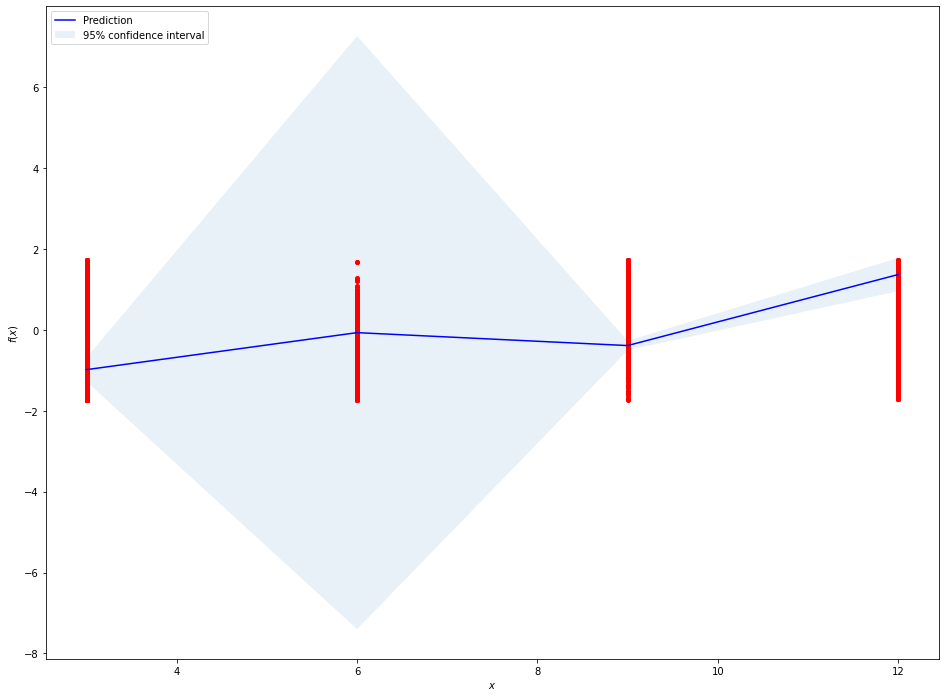

In [22]:
model = start_train(center_df)

In [27]:
np.linspace(0 , 13, 52)

array([ 0.        ,  0.25490196,  0.50980392,  0.76470588,  1.01960784,
        1.2745098 ,  1.52941176,  1.78431373,  2.03921569,  2.29411765,
        2.54901961,  2.80392157,  3.05882353,  3.31372549,  3.56862745,
        3.82352941,  4.07843137,  4.33333333,  4.58823529,  4.84313725,
        5.09803922,  5.35294118,  5.60784314,  5.8627451 ,  6.11764706,
        6.37254902,  6.62745098,  6.88235294,  7.1372549 ,  7.39215686,
        7.64705882,  7.90196078,  8.15686275,  8.41176471,  8.66666667,
        8.92156863,  9.17647059,  9.43137255,  9.68627451,  9.94117647,
       10.19607843, 10.45098039, 10.70588235, 10.96078431, 11.21568627,
       11.47058824, 11.7254902 , 11.98039216, 12.23529412, 12.49019608,
       12.74509804, 13.        ])